In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.


In [5]:
dataset = pd.read_csv('historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [10]:
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [11]:
symbols = trainSet.ticker.unique()

#  Prepare train_set by normalize every symbols

In [12]:
timesteps = 60
def make_samples(data, s):
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data)
    for i in range(timesteps, l):
        sc = MinMaxScaler(feature_range=(0,1))
        x = data[i-timesteps: i, 0]
        x = x.reshape(-1,1)
        sc.partial_fit(x)
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    k = data[i+j-1,0]
                    k = k.reshape(-1,1)
                    sc.partial_fit(k)
                    train_set[s]['X'][j].append(sc.transform(x))
                    train_set[s]['Y'][j].append(sc.transform(k))
                    if k == data[l-1,0]:
                        stop_append[j] =True

In [13]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
for s in symbols:
    train_set.update({s:{
        'X':{},
        'Y':{}
    }})
    for i in prediction_intervals:
        train_set[s]['X'][i] = []
        train_set[s]['Y'][i] = []
    train_stock = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
    make_samples(train_stock, s)

In [18]:
# np.save('train_set_normalize_every_samples.npy', train_set) 

In [21]:
# Define callback function
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=2, mode='min')

In [22]:
# Make GRU model architecture
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units=30, input_shape=(60,1), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [181]:
# Training 4 intervals models with train_set where normalize every samples
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 200
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in train_set[s]['X'][i]:
            x_train.append(j)
        for j in train_set[s]['Y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    Y_train = Y_train.reshape(Y_train.shape[0],1)
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(3125263, 60, 1) (3125263, 1)
Fitting prediction interval 1  model
Train on 2187684 samples, validate on 937579 samples
Epoch 1/200
2187684/2187684 [==============================] - 61s 28us/step - loss: 0.0279 - val_loss: 0.0122
Epoch 2/200
2187684/2187684 [==============================] - 61s 28us/step - loss: 0.0151 - val_loss: 0.0120
Epoch 3/200
2187684/2187684 [==============================] - 60s 27us/step - loss: 0.0141 - val_loss: 0.0119
Epoch 4/200
2187684/2187684 [==============================] - 60s 27us/step - loss: 0.0137 - val_loss: 0.0119
Epoch 5/200
2187684/2187684 [==============================] - 60s 28us/step - loss: 0.0135 - val_loss: 0.0119
Epoch 6/200
2187684/2187684 [==============================] - 60s 27us/step - loss: 0.0135 - val_loss: 0.0119
Epoch 7/200
2187684/2187684 [==============================] - 58s 27us/step - loss: 0.0134 - val_loss: 0.0119
Epoch 8/200
2187684/2187684 [==============================] - 59s 27us/step - loss: 0.0134 - val_loss:

2156553/2156553 [==============================] - 59s 27us/step - loss: 0.0455 - val_loss: 0.0447
Epoch 16/200
2156553/2156553 [==============================] - 57s 26us/step - loss: 0.0449 - val_loss: 0.0432
Epoch 17/200
2156553/2156553 [==============================] - 57s 26us/step - loss: 0.0445 - val_loss: 0.0457
Epoch 18/200
2156553/2156553 [==============================] - 57s 26us/step - loss: 0.0442 - val_loss: 0.0422
Epoch 19/200
2156553/2156553 [==============================] - 57s 26us/step - loss: 0.0437 - val_loss: 0.0422
Epoch 20/200
2156553/2156553 [==============================] - 57s 26us/step - loss: 0.0436 - val_loss: 0.0415
Epoch 21/200
2156553/2156553 [==============================] - 57s 26us/step - loss: 0.0433 - val_loss: 0.0410
Epoch 22/200
2156553/2156553 [==============================] - 57s 27us/step - loss: 0.0430 - val_loss: 0.0411
Epoch 23/200
2156553/2156553 [==============================] - 57s 26us/step - loss: 0.0427 - val_loss: 0.0406
Epoch

In [182]:
# Save model
for i in prediction_intervals:
    model[i].save('normalize_every_samples/model_{}'.format(i))

In [201]:
# Load model
from keras.models import load_model
model = {}
for i in prediction_intervals:
    model[i] = load_model('normalize_every_samples/model_{}'.format(i))

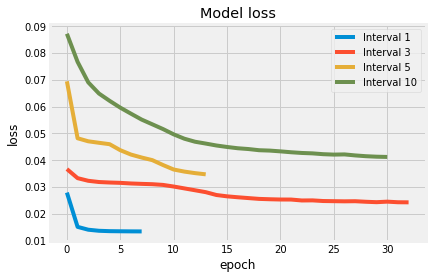

In [183]:
for i in prediction_intervals:
    plt.plot(model_history[i].history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Interval 1', 'Interval 3', 'Interval 5', 'Interval 10'], loc='upper right')
plt.show()

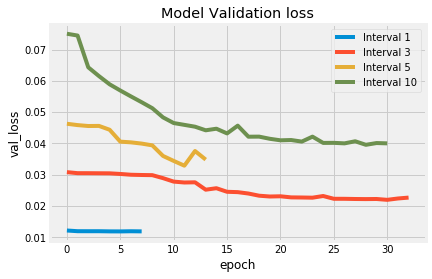

In [184]:
for i in prediction_intervals:
    plt.plot(model_history[i].history['val_loss'])
plt.title('Model Validation loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['Interval 1', 'Interval 3', 'Interval 5', 'Interval 10'], loc='upper right')
plt.show()

In [185]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [420]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Evaluate Model being trained with normalize every samples train_set

In [286]:
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}

    test_set.update({s:{
            'X':{},
            'Y':{}
        }})
    for i in prediction_intervals:
            test_set[s]['X'][i] = []
            test_set[s]['Y'][i] = []
            scaler[s][i] = []

    test_stock = testSet.loc[testSet['ticker'] == s][['adj_close']].values

    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(test_stock)

    for i in range(timesteps, l):
        sc = MinMaxScaler(feature_range=(0,1))
        x = test_stock[i-timesteps: i, 0]
        x = x.reshape(-1,1)
        sc.partial_fit(x)
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    k = test_stock[i+j-1,0]
                    k = k.reshape(-1,1)
                    sc.partial_fit(k)
                    test_set[s]['X'][j].append(sc.transform(x))
                    test_set[s]['Y'][j].append(k)
                    if k == test_stock[l-1,0]:
                        stop_append[j] =True
                scaler[s][j].append(sc)
                
    return test_set, scaler

In [345]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    for i in prediction_intervals:
        x_test = []    
        for j in data[s]['X'][i]:
                x_test.append(j)
        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        result = model[i].predict(X_test)
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])

        y_test = data[s]['Y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
        
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

In [463]:
# Predicting a particular symbol
s = 'AAPL'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

In [464]:
for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of AAPL inveral 1: 19.88494114172331
Test Set -> MSE of AAPL inveral 3: 17.73808382968105
Test Set -> MSE of AAPL inveral 5: 26.496511522128845
Test Set -> MSE of AAPL inveral 10: 24.9810124547541


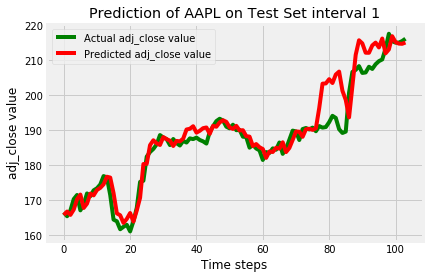

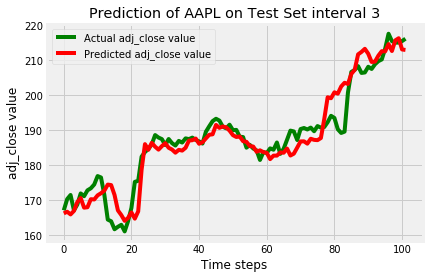

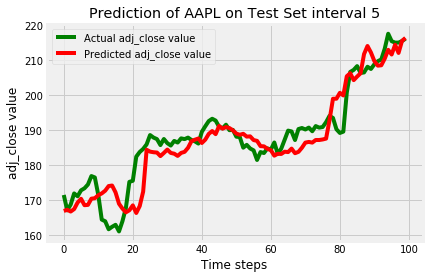

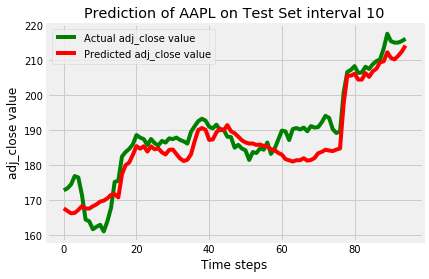

In [465]:
for i in prediction_intervals:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))

# Evaluate model being trained with normalize each symbols train_set

In [146]:
# Load test_set
np_test_set = np.load('normalize_each_symbols/test_set.npy')

In [166]:
for i in np.ndenumerate(np_test_set):
    test_set0 = i[1]

In [173]:
# Load scaler object
np_scaler = np.load('normalize_each_symbols/scaler.npy')

In [174]:
for i in np.ndenumerate(np_scaler):
    scaler0 = i[1]

In [192]:
# Load model being trained with train_set where normalize each symbols
from keras.models import load_model
model_0 = {}
for i in prediction_intervals:
    model_0[i] = load_model('normalize_each_symbols/gru_model_{}.h5'.format(i))

## Predicting

In [295]:
def make_prediction0(s):
    sc = scaler0[s]
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    
    for i in prediction_intervals:
        # Define X_test
        x_test = test_set0[s]['X'][i]
        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        # Define y_true
        y_test = test_set0[s]['Y'][i]
        Y_test = np.array(y_test)
        Y_test = Y_test.reshape(-1,1)
        y_true = sc.inverse_transform(Y_test)

        # Predicting
        result = model_0[i].predict(X_test)
        y_pred = sc.inverse_transform(result)
        
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        # Calculate MSE
        mse_val[i] = return_mse(y_true, y_pred)
    return y_true_val, y_pred_val, mse_val

In [466]:
# Predicting a particular symbol
s = 'AAPL'
y_true_val0, y_pred_val0, mse_val0 = make_prediction0(s)

In [467]:
for i in mse_val0:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val0[i]))

Test Set -> MSE of AAPL inveral 1: 11.85213569678904
Test Set -> MSE of AAPL inveral 3: 24.11321835151213
Test Set -> MSE of AAPL inveral 5: 65.682398228029
Test Set -> MSE of AAPL inveral 10: 141.1460487637035


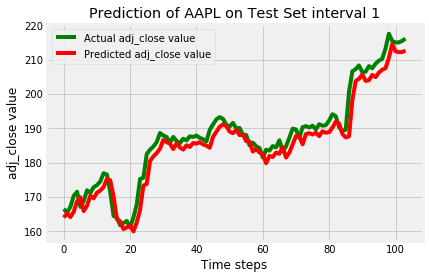

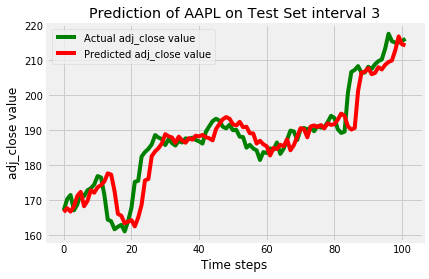

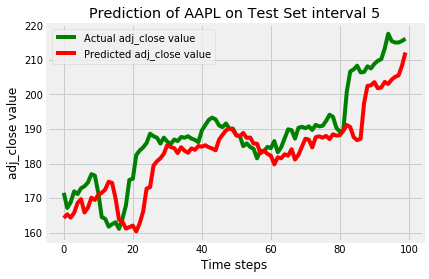

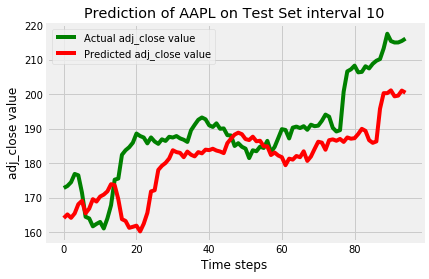

In [468]:
for i in prediction_intervals:
    plotting_graph(y_true_val0[i], y_pred_val0[i], s, 'Test Set interval {}'.format(i))

# Normalize every samples vs Normalize each symbols

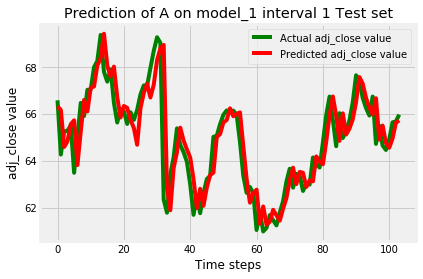

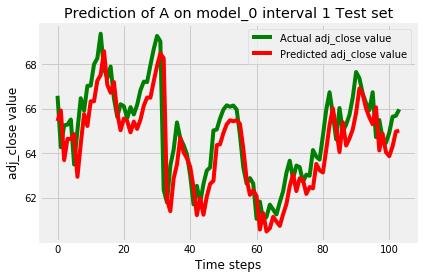

Interval 1 -> MSE (model_0) is 1.4925498244845974 MSE (model_1) is 1.1317200533205658


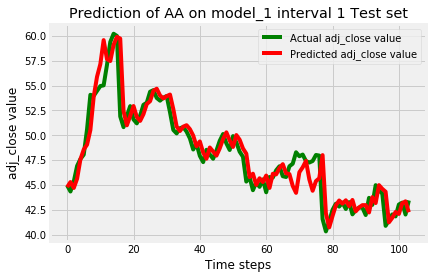

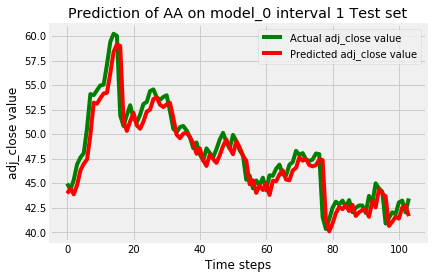

Interval 1 -> MSE (model_0) is 2.416589401279393 MSE (model_1) is 2.763270674938985


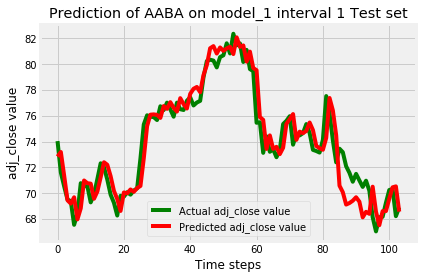

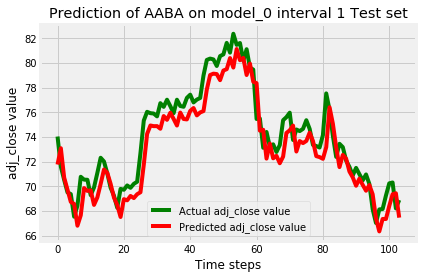

Interval 1 -> MSE (model_0) is 2.2033992827329345 MSE (model_1) is 1.8151374264634792


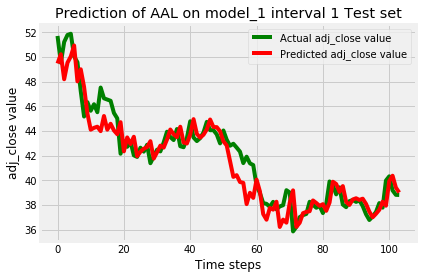

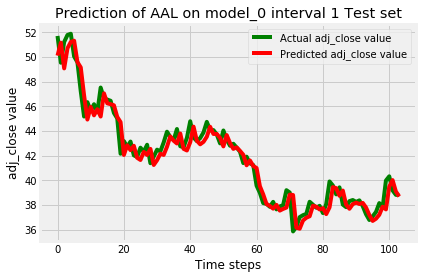

Interval 1 -> MSE (model_0) is 0.8745099746755324 MSE (model_1) is 1.8182399525092094


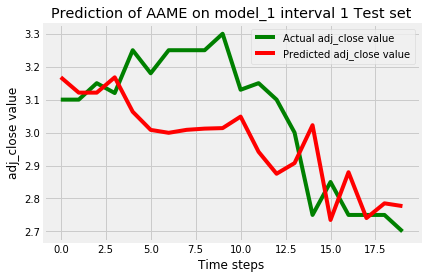

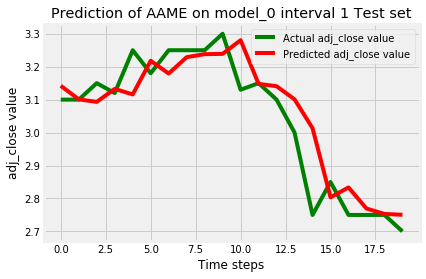

Interval 1 -> MSE (model_0) is 0.007491890124015213 MSE (model_1) is 0.02766589152804768


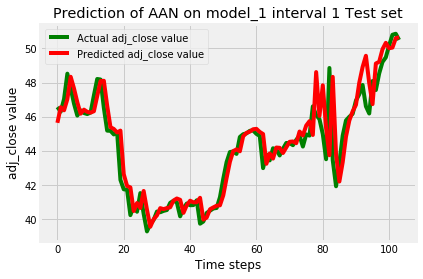

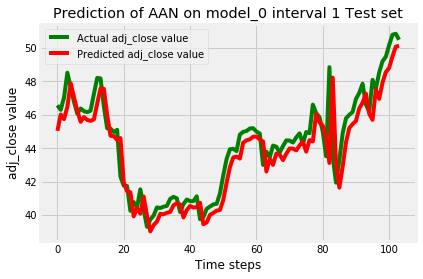

Interval 1 -> MSE (model_0) is 1.4100297669427466 MSE (model_1) is 1.3513681499261883


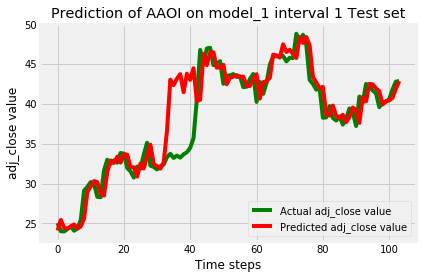

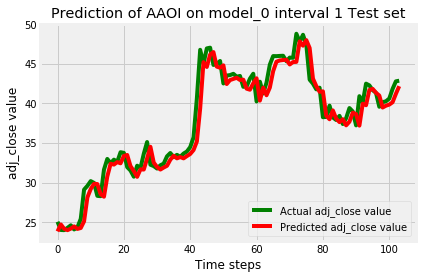

Interval 1 -> MSE (model_0) is 2.8016516577044523 MSE (model_1) is 8.781786661355449


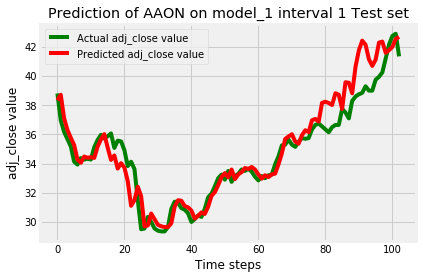

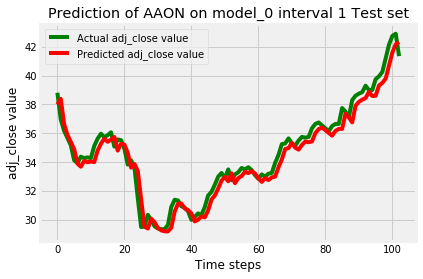

Interval 1 -> MSE (model_0) is 0.4781486998615311 MSE (model_1) is 1.3353217858203061


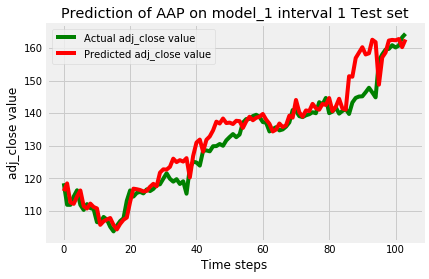

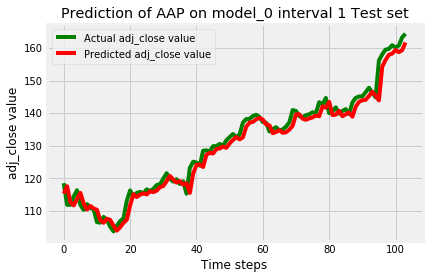

Interval 1 -> MSE (model_0) is 6.844857373889841 MSE (model_1) is 25.68586023898542


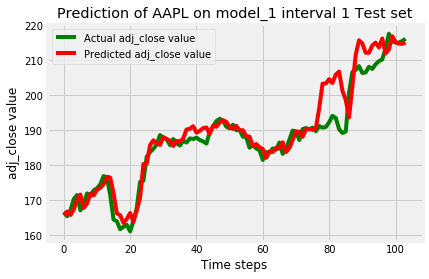

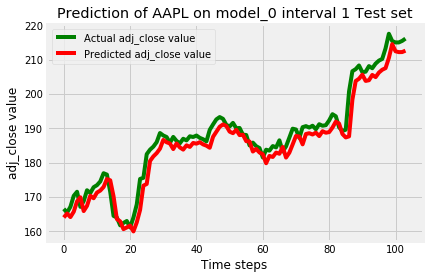

Interval 1 -> MSE (model_0) is 11.85213569678904 MSE (model_1) is 19.88494114172331


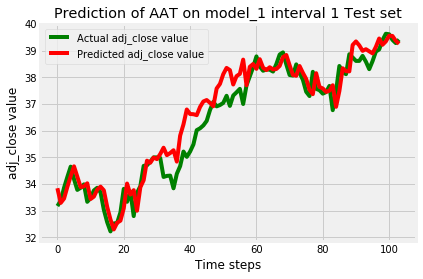

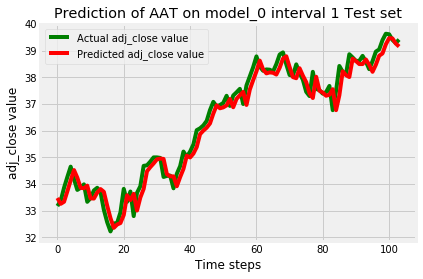

Interval 1 -> MSE (model_0) is 0.17150040822917173 MSE (model_1) is 0.3684291460323561


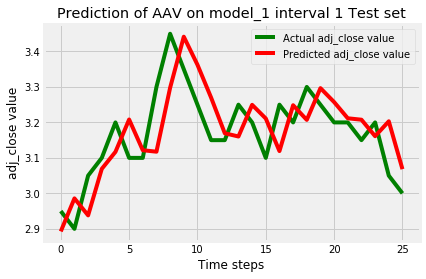

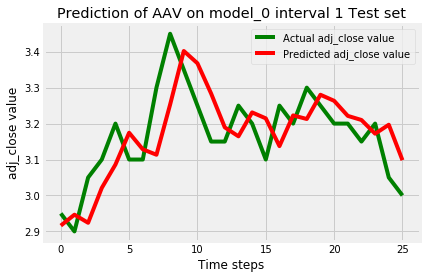

Interval 1 -> MSE (model_0) is 0.009138971925086005 MSE (model_1) is 0.008653717357125614


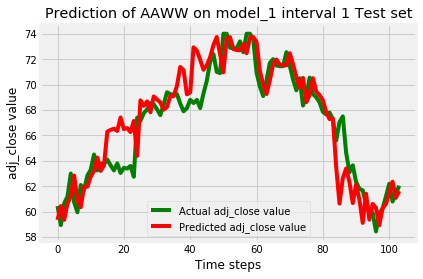

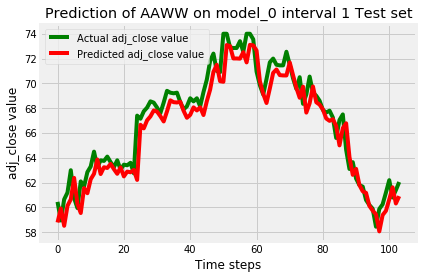

Interval 1 -> MSE (model_0) is 1.7051502137716033 MSE (model_1) is 3.4084661803502168


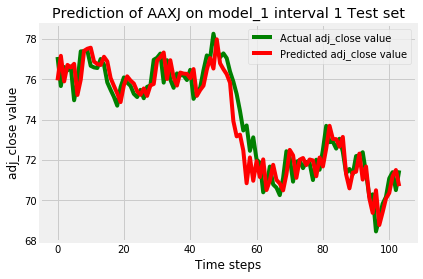

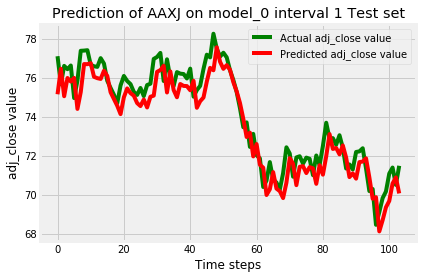

Interval 1 -> MSE (model_0) is 0.8336225461271839 MSE (model_1) is 0.7615037402876939


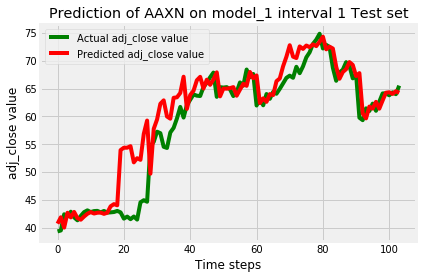

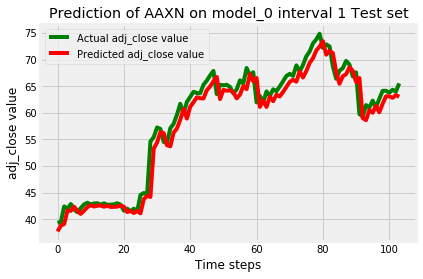

Interval 1 -> MSE (model_0) is 4.737486040508881 MSE (model_1) is 18.018708035548684


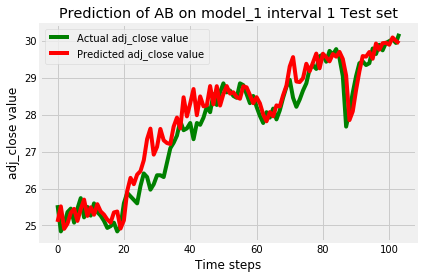

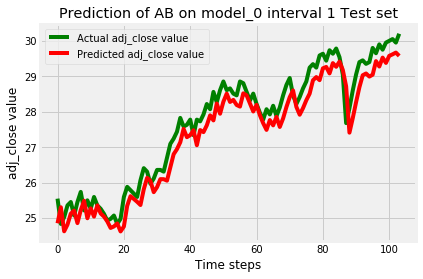

Interval 1 -> MSE (model_0) is 0.21421929874077175 MSE (model_1) is 0.22820654271380025


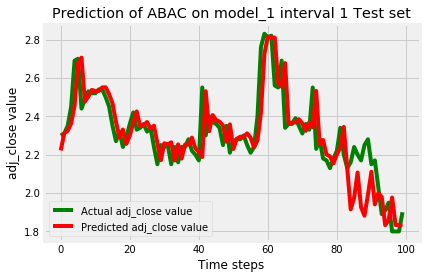

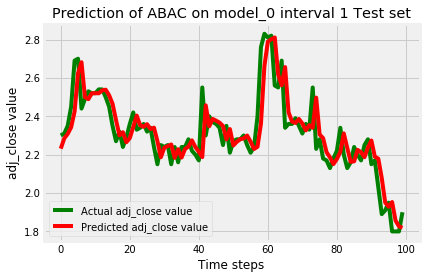

Interval 1 -> MSE (model_0) is 0.011719089580038665 MSE (model_1) is 0.015745487258698378


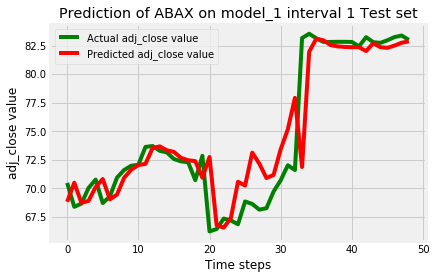

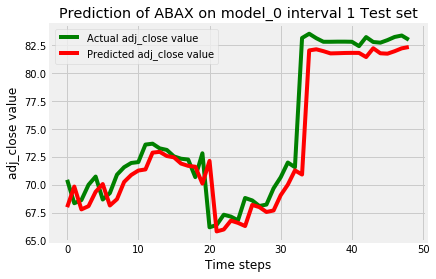

Interval 1 -> MSE (model_0) is 5.3616354650870175 MSE (model_1) is 6.560813057245863


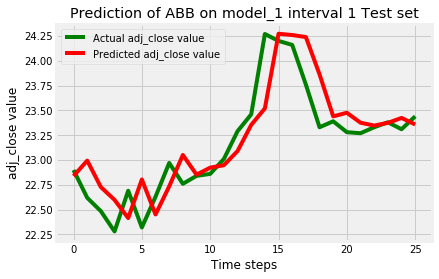

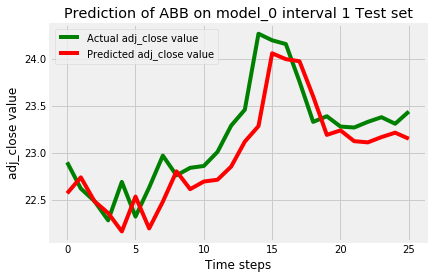

Interval 1 -> MSE (model_0) is 0.10560865628548989 MSE (model_1) is 0.07727531793114917


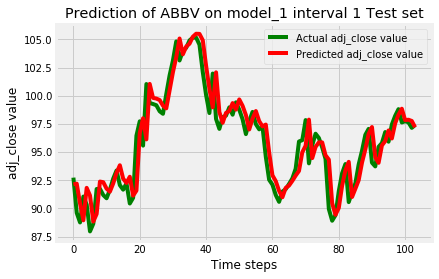

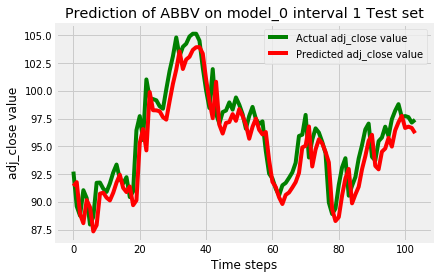

Interval 1 -> MSE (model_0) is 3.6778778445110873 MSE (model_1) is 2.7345227427246575


In [427]:
# 1 mean model trained data where normalize every samples
# 0 mean model trained data where normalize each symbols

test_symbols = symbols[0:20]
all_mse = {'1':{},
           '0':{}
          }
for i in prediction_intervals:
    all_mse['1'][i] = []
    all_mse['0'][i] = []
    
for s in test_symbols:
    # Predicting on model being trained data where normalize every samples
    data, sc = make_test_data(s)
    y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)
    
    # Predicting on model being trained data where normalize each symbols
    y_true_val0, y_pred_val0, mse_val0 = make_prediction0(s)
    
    for i in prediction_intervals:
        all_mse['1'][i].append(mse_val[i])
        all_mse['0'][i].append(mse_val0[i])
    
    plotting_graph(y_true_val[1], y_pred_val[1], s, 'model_1 interval 1 Test set')
    plotting_graph(y_true_val0[1], y_pred_val0[1], s, 'model_0 interval 1 Test set')
    print('Interval 1 -> MSE (model_0) is {} MSE (model_1) is {}'.format(mse_val0[1], mse_val[1]))


### Test loss comparison

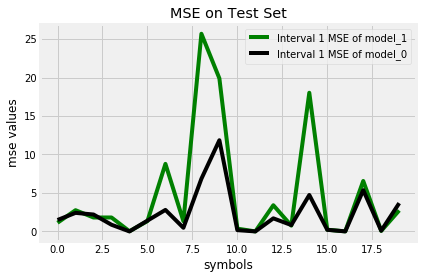

<Figure size 4320x2160 with 0 Axes>

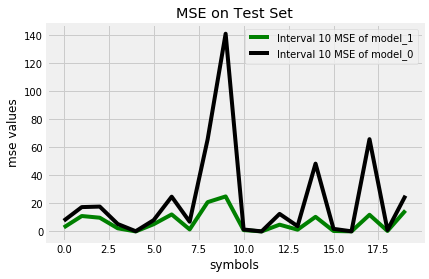

<Figure size 4320x2160 with 0 Axes>

In [428]:
from matplotlib.pyplot import figure
for i in [1,10]:
    #figure(figsize=(10, 6))
    a = all_mse['1'][i]
    b = all_mse['0'][i]
    plt.plot(a, color='green')
    plt.plot(b, color='black')
    plt.title('MSE on Test Set')
    plt.xlabel('symbols', )
    plt.ylabel('mse values')
    plt.legend(['Interval {} MSE of model_1'.format(i), 'Interval {} MSE of model_0'.format(i)], loc='upper right')
    plt.figure(figsize=(60,30))
    plt.show()